## Outros

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!ls gdrive/MyDrive

'Colab Notebooks'   test_images.zip   train_images.zip


In [3]:
! mkdir Test
! mkdir Test/test
! mkdir Modelo
! mkdir Ensemble

mkdir: cannot create directory ‘Test’: File exists
mkdir: cannot create directory ‘Test/test’: File exists
mkdir: cannot create directory ‘Modelo’: File exists
mkdir: cannot create directory ‘Ensemble’: File exists


In [4]:
!unzip gdrive/MyDrive/train_images.zip 

Archive:  gdrive/MyDrive/train_images.zip
replace GTSRB/Final_Training/Images/00000/00000_00000.ppm? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
!unzip gdrive/MyDrive/test_images.zip -d Test/test

Archive:  gdrive/MyDrive/test_images.zip
replace Test/test/00000/00243.ppm? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Bibliotecas

In [6]:
#!pip install scikit-image
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, LeakyReLU 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from skimage.color import rgb2lab
from skimage.transform import resize
import collections

# plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib
from PIL import Image
import IPython.display as display

# to display confusion matrix
import seaborn as sn
import pandas as pd

import glob

import math
from math import floor
from math import ceil

matplotlib.style.use('ggplot')


In [8]:
def set_keras_backend(backend):
    print("A acertar o backend e libertar memória da grafica")
    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        importlib.reload(K)
        assert K.backend() == backend
    if backend == "tensorflow":
        # Allow memory growth for the GPU
        physical_devices = tf.config.experimental.list_physical_devices('GPU')
        print(physical_devices)
        tf.config.experimental.set_memory_growth(physical_devices[0], True)


def limit_mem():
    K.get_session().close()
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))

set_keras_backend("tensorflow")
#limit_mem()

A acertar o backend e libertar memória da grafica
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Funções necessárias

In [9]:
def to_tf_format(imgs):
  return np.stack([img[:, :] for img in imgs], axis=0).astype(np.float32)

In [10]:
def read_dataset_ppm(rootpath, n_labels, resize_to):
  images = []
  labels = []
  for c in range(n_labels):
    full_path = rootpath + '/' + format(c, '05d') + '/'
    for img_name in glob.glob(full_path + "*.ppm"):
      img = plt.imread(img_name).astype(np.float32)
      img = img / 255.0
      if resize_to:
        img = resize(img, resize_to, mode='reflect')
      
      label = np.zeros((n_labels, ), dtype=np.float32)
      label[c] = 1.0
      images.append(img.astype(np.float32))
      labels.append(label)
  return tf.data.Dataset.from_tensor_slices((to_tf_format(images).astype(np.float32), np.matrix(labels).astype(np.float32)))

In [11]:
def show_history(history):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()    

In [12]:
def show_accuracies(labels, test, val): 
    fig, ax = plt.subplots()
    X = np.arange(len(test))

    plt.bar(X, test, width = 0.4, color = 'b', label='test')
    plt.bar(X + 0.4, val, color = 'r', width = 0.4, label = "val")
    plt.xticks(X + 0.4 / 2, labels)
    plt.ylim(top = 1.0, bottom = 0.90)
    plt.legend(loc='upper left')
    plt.show()    

In [13]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label, img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
      color = 'blue'
    else:
      color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(classNames[predicted_label], 100*np.max(predictions_array), classNames[true_label]), color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(8))
    plt.yticks([])
    thisplot = plt.bar(range(8), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[np.where(true_label)[0][0]].set_color('blue')   

In [14]:
def prepare_callbacks(file_path):
    checkpointer = ModelCheckpoint(filepath= file_path, monitor = 'val_accuracy', verbose=1, save_weights_only=True, save_best_only=True)
    earlyStopper = EarlyStopping(monitor='val_loss', min_delta = 0.0001, patience = 15, verbose = 1)
    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000000001, verbose = 1)
    return [checkpointer, earlyStopper, reduceLR]

## Tamanho do Batch

In [15]:
BATCH_SIZE = 64
IMAGE_SIZE = 30
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Importar imagens 

In [16]:
TRAIN_IMAGE_DIR = 'GTSRB/Final_Training/Images/'
TEST_IMAGE_DIR = 'Test/test/'
MODELS_DIR = 'Modelo/'
MODELS_ENSEMBLES_DIR = 'Ensemble/'

In [17]:
data_dir = pathlib.Path(TRAIN_IMAGE_DIR)

classNames = np.array(os.listdir(data_dir))
classNames = classNames.tolist()
NUM_CLASSES = len(classNames)
classNames
print(f'List: {classNames}')


List: ['00001', '00012', '00000', '00031', '00026', '00033', '00032', '00027', '00022', '00042', '00002', '00016', '00025', '00006', '00020', '00036', '00014', '00038', '00011', '00010', '00029', '00017', '00030', '00041', '00040', '00008', '00015', '00003', '00007', '00023', '00013', '00035', '00034', '00018', '00009', '00021', '00019', '00024', '00004', '00005', '00037', '00028', '00039']


In [18]:
print("Número de classes: {:}".format(NUM_CLASSES))

Número de classes: 43


### Loading das imagens

In [19]:
dataset_full = read_dataset_ppm(TRAIN_IMAGE_DIR, NUM_CLASSES, (IMAGE_SIZE,IMAGE_SIZE))
dataset_full_length = tf.data.experimental.cardinality(dataset_full).numpy()

train_size = math.floor(0.8 * dataset_full_length)
val_size = math.ceil(0.2 * dataset_full_length)

dataset = dataset_full.shuffle(buffer_size = dataset_full_length)
trainset = dataset.skip(val_size)
valset = dataset.take(val_size) 
dataset = trainset

### Informação sobre o shape da imagem e o tamanho do training set

In [20]:
t1 = next(iter(valset))
print(t1[0].shape, t1[1].shape)
t = next(iter(dataset))
print(t[0].shape, t[1].shape)

dataset_length = tf.data.experimental.cardinality(dataset).numpy()

print("\nTotal de imagens no daset completo: ", dataset_full_length)

print("\nApós o split")
print("\nTotal de imagens no dataset de treino: ", dataset_length)  

(30, 30, 3) (43,)
(30, 30, 3) (43,)

Total de imagens no daset completo:  39209

Após o split

Total de imagens no dataset de treino:  31367


### Preparação do dataset de treino, validação e teste

In [21]:
dataSolo = dataset
dataSolo = dataSolo.cache()
dataSolo = dataSolo.shuffle(buffer_size = dataset_length)
dataSolo = dataSolo.prefetch(buffer_size=10200)
dataSolo = dataSolo.batch(batch_size=BATCH_SIZE)
#dataSolo = dataSolo.repeat()

In [22]:
val_dataset_length = valset.cardinality().numpy()
print("Total de imagens no dataset de validação: ", val_dataset_length)

valset = valset.cache()
valset = valset.shuffle(buffer_size = 2580)
valset = valset.batch(batch_size = 2580)
valset = valset.prefetch(buffer_size = AUTOTUNE)

Total de imagens no dataset de validação:  7842


In [23]:
testset = read_dataset_ppm(TEST_IMAGE_DIR, NUM_CLASSES, (IMAGE_SIZE,IMAGE_SIZE))
test_dataset_length = testset.cardinality().numpy()
print("Total images in test dataset: ", test_dataset_length)

testset = testset.batch(batch_size = BATCH_SIZE)

Total images in test dataset:  12630


## Ver imagens

In [24]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [30,30])

In [25]:
def show_batch(image_batch, label_batch):
  columns = 6
  rows = BATCH_SIZE / columns + 1  
  plt.figure(figsize=(10, 2 * rows))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(int(rows), columns, n+1)
      plt.imshow((image_batch[n]))
      plt.axis('off')

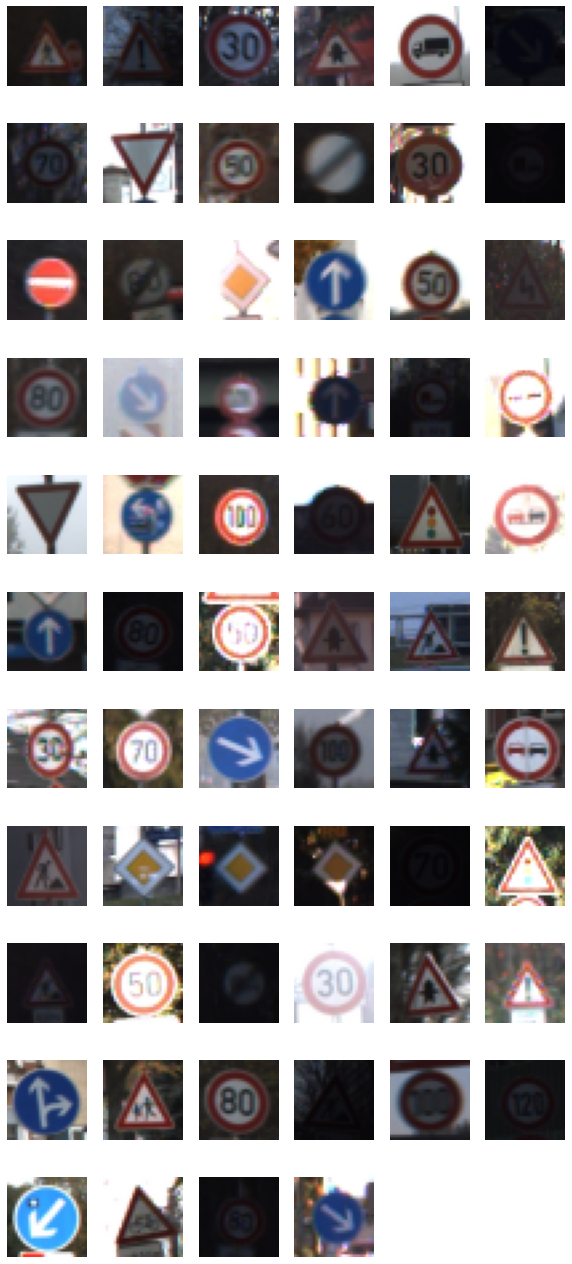

In [26]:
image_batch, label_batch = next(iter(dataSolo))        
show_batch(image_batch, label_batch.numpy())

## Modelo

In [27]:
def model_VI(classCount, imgSize, channels):

    model = Sequential()
    
    model.add(Conv2D(64, (5, 5), input_shape=(imgSize, imgSize, channels)))         
    model.add(LeakyReLU(alpha=0.01))  
    model.add(BatchNormalization())
    model.add(Dropout(0.5)) 

    model.add(Conv2D(128, (5, 5) )) 
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5)) 

    model.add(Conv2D(256, (5, 5) ) )
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5)) 
    
    model.add(Flatten())
    model.add(LeakyReLU(alpha=0.0)) 
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.0))             
    model.add(Dropout(0.5)) 
    
    model.add(Dense(classCount, activation='softmax'))
    
    opt = Adam(lr=0.0001)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ 'accuracy'])
    return model

## Sem Data Augmentation

In [30]:
modelsolo = model_VI(NUM_CLASSES, 30, 3)
modelsolo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        4864      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 26, 26, 64)        0         
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 64)       256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 26, 26, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 128)       204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 22, 22, 128)       0         
                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [36]:
file_pathsolo = os.path.join(MODELS_DIR, 'modelsolo/cp.ckpt')

callbackssolo = prepare_callbacks(file_pathsolo)

Epoch 1/20
491/491 [==============================] - ETA: 0s - loss: 2.9687 - accuracy: 0.2535
Epoch 1: val_accuracy improved from -inf to 0.48189, saving model to Modelo/modelsolo/cp.ckpt
491/491 [==============================] - 23s 21ms/step - loss: 2.9687 - accuracy: 0.2535 - val_loss: 2.1355 - val_accuracy: 0.4819 - lr: 1.0000e-04
Epoch 2/20
487/491 [============================>.] - ETA: 0s - loss: 1.4274 - accuracy: 0.5896
Epoch 2: val_accuracy improved from 0.48189 to 0.86738, saving model to Modelo/modelsolo/cp.ckpt
491/491 [==============================] - 8s 16ms/step - loss: 1.4245 - accuracy: 0.5903 - val_loss: 0.4814 - val_accuracy: 0.8674 - lr: 1.0000e-04
Epoch 3/20
488/491 [============================>.] - ETA: 0s - loss: 0.7718 - accuracy: 0.7660
Epoch 3: val_accuracy improved from 0.86738 to 0.94415, saving model to Modelo/modelsolo/cp.ckpt
491/491 [==============================] - 8s 16ms/step - loss: 0.7711 - accuracy: 0.7661 - val_loss: 0.2044 - val_accuracy: 

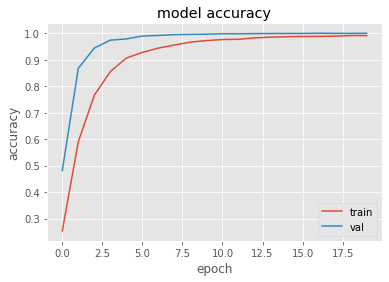

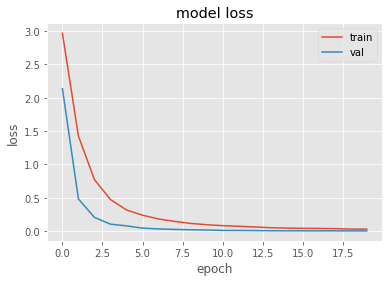

In [ ]:
historysolo = modelsolo.fit(dataSolo, epochs=20, validation_data = valset, callbacks = callbackssolo)     
show_history(historysolo)

In [ ]:
modelsolo.load_weights(file_pathsolo)

evalsolo = modelsolo.evaluate(testset, verbose=2)
valsolo = modelsolo.evaluate(valset, verbose=2)

198/198 - 1s - loss: 0.0696 - accuracy: 0.9801 - 1s/epoch - 7ms/step
4/4 - 1s - loss: 0.0026 - accuracy: 1.0000 - 930ms/epoch - 233ms/step


## Data Augmentation (Dynamic)

### Versão 1

In [86]:
def process_image(image, label):
    
    # random rotate 5 degrees
    r = tf.random.uniform(shape=(), minval=-0.175, maxval=0.175, dtype=tf.dtypes.float32)
    image = tfa.image.rotate(image, r)

    # translate image up to 10%
    rx = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32) 
    ry = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32) 
    image = tfa.image.translate(image, [rx, ry])
   
    # change hue, saturation and value
    image = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.2, 0.4, 1.1, 0.4, 1.1),0,1)

    return image, label

In [87]:
dataV2 = dataset
dataV2 = dataV2.cache()
dataV2 = dataV2.shuffle(buffer_size = dataset_length)
dataV2 = dataV2.map(process_image)
dataV2 = dataV2.batch(batch_size=BATCH_SIZE)
#dataV2 = dataV2.repeat()

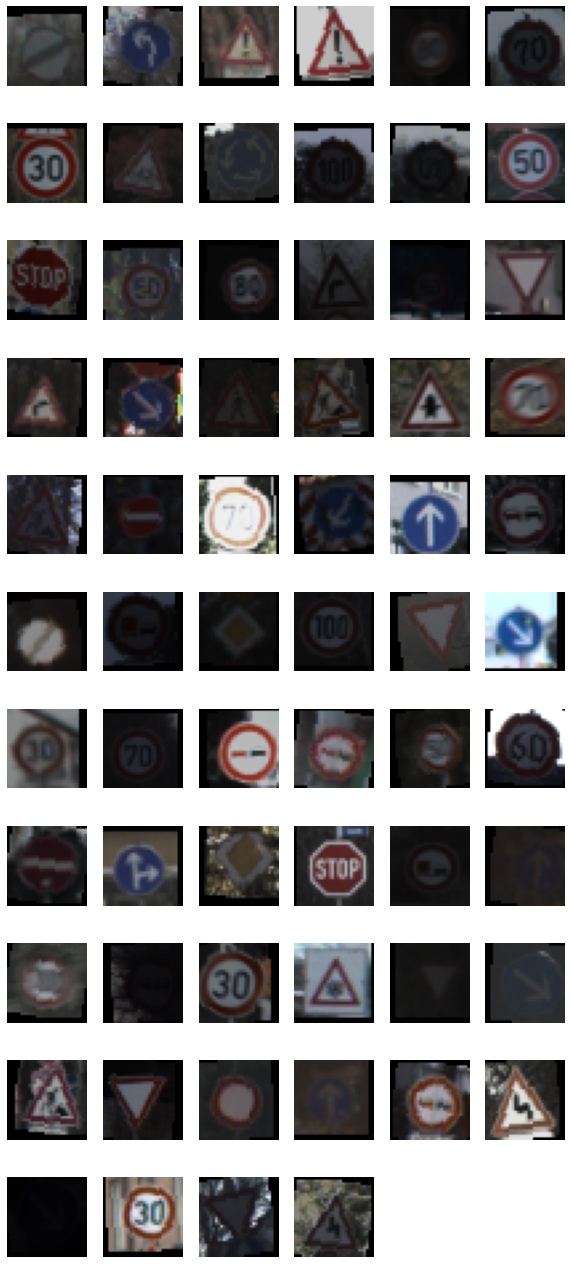

In [88]:
image_batch, label_batch = next(iter(dataV2))        
show_batch(image_batch, label_batch.numpy())

In [89]:
modelV2 = model_VI(NUM_CLASSES, 30, 3)

file_pathV2 = 'DA_modelV2/cp.ckpt'

callbacksV2 = prepare_callbacks(file_pathV2)
historyV2 = modelV2.fit(dataV2, epochs=30, validation_data = valset, callbacks = callbacksV2)      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
490/491 [============================>.] - ETA: 0s - loss: 3.5082 - accuracy: 0.1202
Epoch 1: val_accuracy improved from -inf to 0.24484, saving model to DA_modelV2/cp.ckpt
491/491 [==============================] - 16s 31ms/step - loss: 3.5082 - accuracy: 0.1201 - val_loss: 2.9299 - val_accuracy: 0.2448 - lr: 1.0000e-04
Epoch 2/30
489/491 [============================>.] - ETA: 0s - loss: 2.6771 - accuracy: 0.2767
Epoch 2: val_accuracy improved from 0.24484 to 0.60495, saving model to DA_modelV2/cp.ckpt
491/491 [==============================] - 16s 32ms/step - loss: 2.6765 - accuracy: 0.2769 - val_loss: 1.4186 - val_accuracy: 0.6049 - lr: 1.0000e-04
Epoch 3/30
490/491 [============================>.] - ETA: 0s - loss: 2.0359 - accuracy: 0.4177
Epoch 3: val_accuracy improved from 0.60495 to 0.73922, saving model to DA_modelV2/cp.ckpt
491/491 [==============================] - 15s 30ms/step - loss: 2.0360 - accuracy: 0.4176 - val_loss: 0.8612 - val_accuracy: 0.7392 - lr: 1.0

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


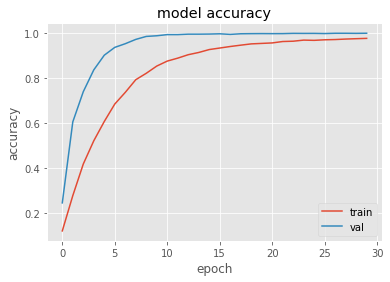

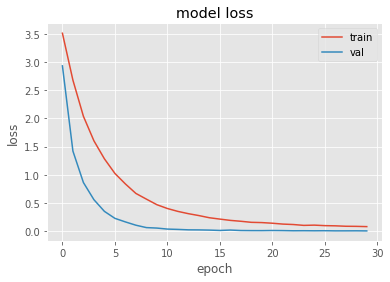

198/198 - 1s - loss: 0.0471 - accuracy: 0.9871 - 1s/epoch - 7ms/step
4/4 - 1s - loss: 0.0033 - accuracy: 0.9992 - 940ms/epoch - 235ms/step


In [90]:
show_history(historyV2)

modelV2.load_weights(file_pathV2)

evalV2 = modelV2.evaluate(testset, verbose=2)
valV2 = modelV2.evaluate(valset, verbose=2)

### Versão 2

Apenas com processamento de imagem relativo à luz (brilho, contraste, hue e saturação)

In [91]:
def process_image_lighting(image,label): #Random augmentation related to lighting
    image = tf.image.random_brightness(image, 1,) #apply random brightness
    image = tf.image.random_contrast(image, 1, 2,) #apply random contrast
    image = tf.image.random_hue(image, 0) #apply random hue
    image = tf.image.random_saturation(image, 1, 2,) #apply random saturation
    return image,label

In [92]:
dataV2_1 = dataset
dataV2_1 = dataV2_1.cache()
dataV2_1 = dataV2_1.shuffle(buffer_size = dataset_length)
dataV2_1 = dataV2_1.map(process_image_lighting)
dataV2_1 = dataV2_1.batch(batch_size=BATCH_SIZE)
#dataV2 = dataV2.repeat()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

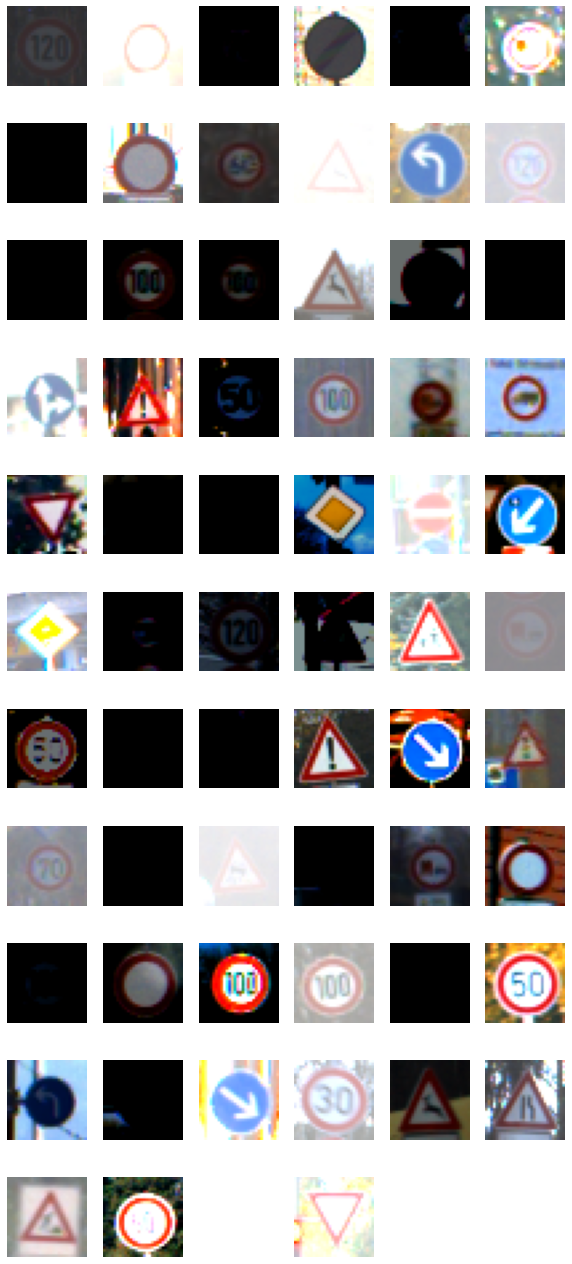

In [93]:
image_batch, label_batch = next(iter(dataV2_1))        
show_batch(image_batch, label_batch.numpy())

In [94]:
modelV2_1 = model_VI(NUM_CLASSES, 30, 3)

file_pathV2_1 = 'DA_modelV2/cp.ckpt'

callbacksV2_1 = prepare_callbacks(file_pathV2_1)
historyV2_1 = modelV2_1.fit(dataV2_1, epochs=30, validation_data = valset, callbacks = callbacksV2_1)      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
489/491 [============================>.] - ETA: 0s - loss: 3.4529 - accuracy: 0.1441
Epoch 1: val_accuracy improved from -inf to 0.23680, saving model to DA_modelV2/cp.ckpt
491/491 [==============================] - 9s 16ms/step - loss: 3.4506 - accuracy: 0.1446 - val_loss: 2.8399 - val_accuracy: 0.2368 - lr: 1.0000e-04
Epoch 2/30
488/491 [============================>.] - ETA: 0s - loss: 2.1531 - accuracy: 0.4146
Epoch 2: val_accuracy improved from 0.23680 to 0.75057, saving model to DA_modelV2/cp.ckpt
491/491 [==============================] - 8s 16ms/step - loss: 2.1504 - accuracy: 0.4151 - val_loss: 0.9352 - val_accuracy: 0.7506 - lr: 1.0000e-04
Epoch 3/30
488/491 [============================>.] - ETA: 0s - loss: 1.2072 - accuracy: 0.6473
Epoch 3: val_accuracy improved from 0.75057 to 0.90309, saving model to DA_modelV2/cp.ckpt
491/491 [==============================] - 8s 15ms/step - loss: 1.2061 - accuracy: 0.6476 - val_loss: 0.4032 - val_accuracy: 0.9031 - lr: 1.0000

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


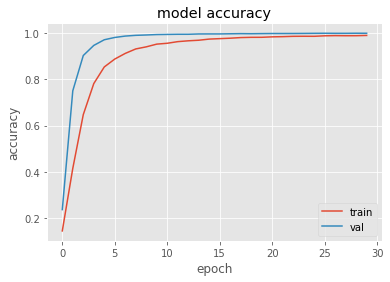

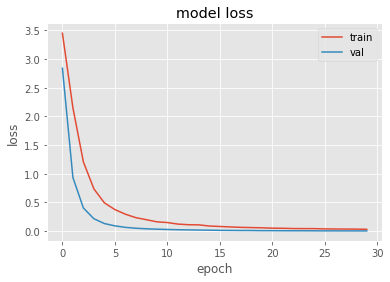

198/198 - 1s - loss: 0.0635 - accuracy: 0.9813 - 1s/epoch - 6ms/step
4/4 - 1s - loss: 0.0047 - accuracy: 0.9994 - 927ms/epoch - 232ms/step


In [95]:
show_history(historyV2_1)

modelV2_1.load_weights(file_pathV2_1)

evalV2_1 = modelV2_1.evaluate(testset, verbose=2)
valV2_1 = modelV2_1.evaluate(valset, verbose=2)

### Versão 3

Gray scale

In [96]:
def process_image_gray(image,label,keep_channels=True): 
    image = tf.image.rgb_to_grayscale(image) 
    if keep_channels:
      image = tf.tile(image, [1, 1, 3])
    return image,label

In [97]:
dataV2_2 = dataset
dataV2_2 = dataV2_2.cache()
dataV2_2 = dataV2_2.shuffle(buffer_size = dataset_length)
dataV2_2 = dataV2_2.map(process_image_gray)
dataV2_2 = dataV2_2.batch(batch_size=BATCH_SIZE)

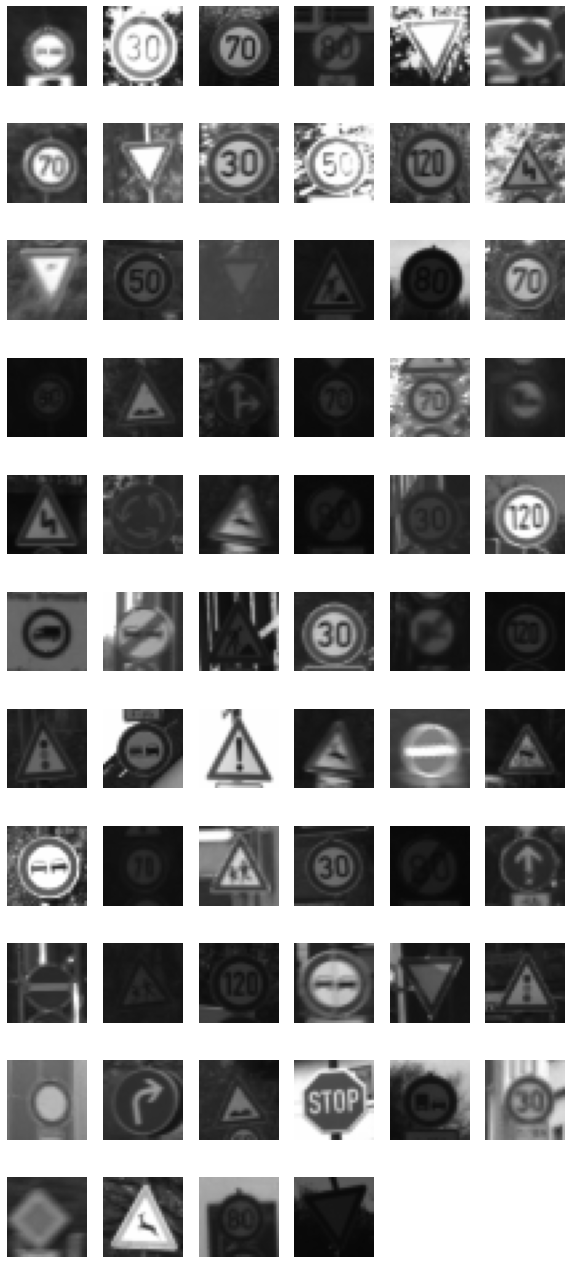

In [98]:
image_batch, label_batch = next(iter(dataV2_2))        
show_batch(image_batch, label_batch.numpy())

In [99]:
modelV2_2 = model_VI(NUM_CLASSES, 30, 3)

file_pathV2_2 = 'DA_modelV2/cp.ckpt'

callbacksV2_2 = prepare_callbacks(file_pathV2_2)
historyV2_2 = modelV2_2.fit(dataV2_1, epochs=30, validation_data = valset, callbacks = callbacksV2_2)  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
488/491 [============================>.] - ETA: 0s - loss: 3.5247 - accuracy: 0.1278
Epoch 1: val_accuracy improved from -inf to 0.16807, saving model to DA_modelV2/cp.ckpt
491/491 [==============================] - 8s 16ms/step - loss: 3.5215 - accuracy: 0.1285 - val_loss: 3.0275 - val_accuracy: 0.1681 - lr: 1.0000e-04
Epoch 2/30
490/491 [============================>.] - ETA: 0s - loss: 2.2566 - accuracy: 0.3938
Epoch 2: val_accuracy improved from 0.16807 to 0.72533, saving model to DA_modelV2/cp.ckpt
491/491 [==============================] - 8s 15ms/step - loss: 2.2566 - accuracy: 0.3938 - val_loss: 0.9837 - val_accuracy: 0.7253 - lr: 1.0000e-04
Epoch 3/30
489/491 [============================>.] - ETA: 0s - loss: 1.2228 - accuracy: 0.6502
Epoch 3: val_accuracy improved from 0.72533 to 0.88345, saving model to DA_modelV2/cp.ckpt
491/491 [==============================] - 8s 15ms/step - loss: 1.2223 - accuracy: 0.6504 - val_loss: 0.4115 - val_accuracy: 0.8834 - lr: 1.0000

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


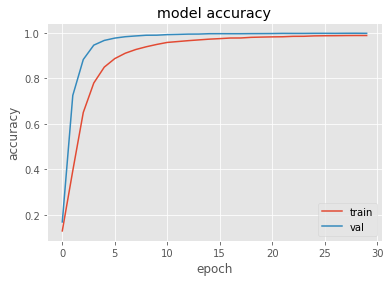

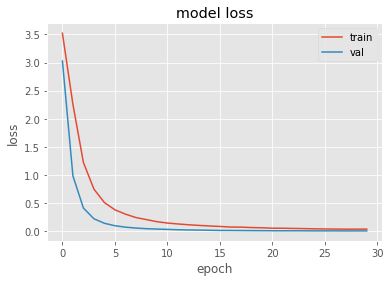

198/198 - 2s - loss: 0.0709 - accuracy: 0.9799 - 2s/epoch - 8ms/step
4/4 - 1s - loss: 0.0047 - accuracy: 0.9991 - 937ms/epoch - 234ms/step


In [100]:
show_history(historyV2_2)

modelV2_2.load_weights(file_pathV2_2)

evalV2_2 = modelV2_2.evaluate(testset, verbose=2)
valV2_2 = modelV2_2.evaluate(valset, verbose=2)

### Comparaçao versões dynamic data augmentation


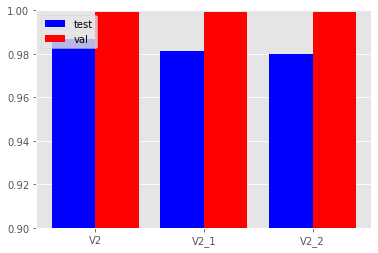

In [101]:
show_accuracies(['V2','V2_1','V2_2'], [evalV2[1], evalV2_1[1], evalV2_2[1]], [valV2[1], valV2_1[1], valV2_2[1]])

## Data Augmentation (Massive)

In [29]:
import tensorflow_addons as tfa

def process_image_gray(image,label,keep_channels=True): 
    image = tf.image.rgb_to_grayscale(image) 
    if keep_channels:
      image = tf.tile(image, [1, 1, 3])
    return image,label

def process_brightness(image, label):
    
    img = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.0, 1.0, 1.0, 0.1, 3.0),0,1)
    return img, label

def process_saturation(image, label):
    
    img = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.0, 1.0, 3.0, 1.0, 1.0),0,1)
    return img, label

def process_contrast(image, label):
    
    img = tf.clip_by_value(tf.image.random_contrast(image, lower=0.1, upper=3.0, seed=None), 0, 1)
    return img, label

def process_hue(image, label):
    
    img = tf.image.random_hue(image, max_delta=0.2, seed=None)
    return img, label

def process_rotate(image, label):
    
    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    return img, label

def process_shear(image, label):
    
    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    sx = tf.random.uniform(shape=(), minval=-0.1, maxval=0.1, dtype=tf.dtypes.float32)
    img = tfa.image.transform(img, [1, sx, -sx*32,   0,1,0,  0,0])
    return img, label

def process_translate(image, label):

    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    tx = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32)
    ty = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32)  
    img = tfa.image.translate(img, [tx,ty])
    return img, label

def process_crop(image, label):
    
    c = tf.random.uniform(shape=(), minval=24, maxval=30, dtype=tf.dtypes.float32)
    img = tf.image.random_crop(image, size=[c,c,3])
    img = tf.image.resize(img ,size= [30,30])
    return img, label

#### Versão 1

In [119]:
dataVA = dataset
# color ops
dataVA = dataVA.map(process_brightness)
dataVA = dataVA.concatenate(dataset.map(process_contrast))
dataVA = dataVA.concatenate(dataset.map(process_hue))
dataVA = dataVA.concatenate(dataset.map(process_saturation))

#geometry ops
dataVA = dataVA.concatenate(dataset.map(process_rotate))
dataVA = dataVA.concatenate(dataset.map(process_shear))
dataVA = dataVA.concatenate(dataset.map(process_translate))
dataVA = dataVA.concatenate(dataset.map(process_crop))

dataVA = dataVA.cache()
dataVA = dataVA.shuffle(buffer_size = 81600)
dataVA = dataVA.batch(batch_size = BATCH_SIZE)
dataVA = dataVA.prefetch(buffer_size = AUTOTUNE)
#dataVA = dataVA.repeat()

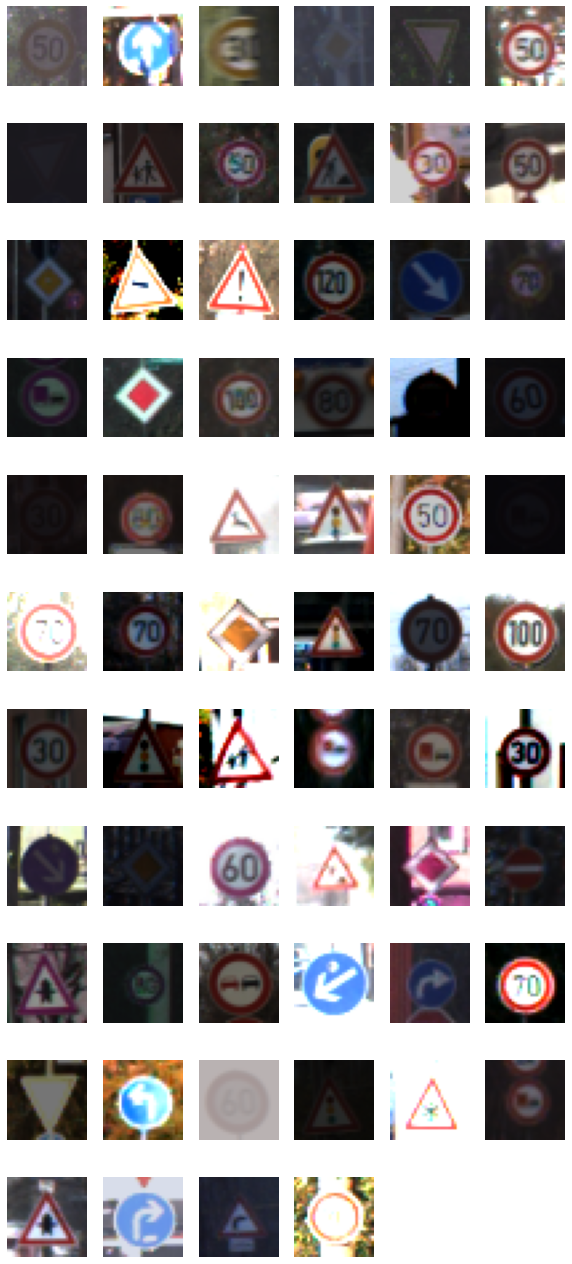

In [120]:
image_batch, label_batch = next(iter(dataVA))        
show_batch(image_batch, label_batch.numpy())

In [ ]:
modelVA = model_VI(NUM_CLASSES, 30, 3)
modelVA.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 64)        4864      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 26, 26, 64)        0         
                                                                 
 batch_normalization_6 (Batc  (None, 26, 26, 64)       256       
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 26, 26, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 22, 22, 128)       204928    
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 22, 22, 128)       0         
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
file_pathVA = os.path.join(MODELS_DIR, 'modelVA/cp.ckpt')

callbacksVA = prepare_callbacks(file_pathVA)

Epoch 1/10
3921/3921 [==============================] - ETA: 0s - loss: 1.1930 - accuracy: 0.6729
Epoch 1: val_accuracy improved from -inf to 0.98827, saving model to Modelo/modelVA/cp.ckpt
3921/3921 [==============================] - 78s 18ms/step - loss: 1.1930 - accuracy: 0.6729 - val_loss: 0.0509 - val_accuracy: 0.9883 - lr: 1.0000e-04
Epoch 2/10
3918/3921 [============================>.] - ETA: 0s - loss: 0.2479 - accuracy: 0.9270
Epoch 2: val_accuracy improved from 0.98827 to 0.99796, saving model to Modelo/modelVA/cp.ckpt
3921/3921 [==============================] - 55s 14ms/step - loss: 0.2479 - accuracy: 0.9270 - val_loss: 0.0118 - val_accuracy: 0.9980 - lr: 1.0000e-04
Epoch 3/10
3919/3921 [============================>.] - ETA: 0s - loss: 0.1380 - accuracy: 0.9591
Epoch 3: val_accuracy improved from 0.99796 to 0.99885, saving model to Modelo/modelVA/cp.ckpt
3921/3921 [==============================] - 58s 15ms/step - loss: 0.1379 - accuracy: 0.9591 - val_loss: 0.0043 - val_ac

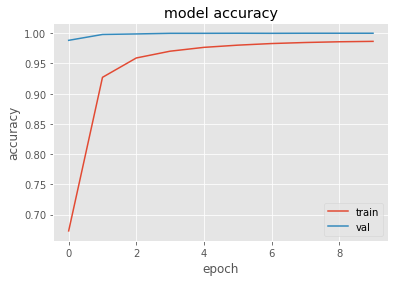

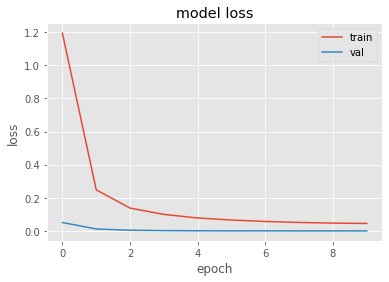

In [ ]:
historyVA = modelVA.fit(dataVA, epochs=10, validation_data = valset, callbacks = callbacksVA)     
show_history(historyVA)

In [ ]:
modelVA.load_weights(file_pathVA)

evalVa = modelVA.evaluate(testset, verbose=2)
valVA = modelVA.evaluate(valset, verbose=2)

198/198 - 1s - loss: 0.0302 - accuracy: 0.9913 - 1s/epoch - 6ms/step
4/4 - 1s - loss: 3.9995e-04 - accuracy: 1.0000 - 980ms/epoch - 245ms/step


### Versão 2

In [30]:
dataVA_2 = dataset
# color ops
dataVA_2 = dataVA_2.map(process_image_gray)
dataVA_2 = dataVA_2.concatenate(dataset.map(process_contrast))
dataVA_2 = dataVA_2.concatenate(dataset.map(process_hue))
dataVA_2 = dataVA_2.concatenate(dataset.map(process_saturation))
dataVA_2 = dataVA_2.concatenate(dataset.map(process_brightness))


#geometry ops
dataVA_2 = dataVA_2.concatenate(dataset.map(process_rotate))
dataVA_2 = dataVA_2.concatenate(dataset.map(process_shear))
dataVA_2 = dataVA_2.concatenate(dataset.map(process_translate))
dataVA_2 = dataVA_2.concatenate(dataset.map(process_crop))

dataVA_2 = dataVA_2.cache()
dataVA_2 = dataVA_2.shuffle(buffer_size = 81600)
dataVA_2 = dataVA_2.batch(batch_size = BATCH_SIZE)
dataVA_2 = dataVA_2.prefetch(buffer_size = AUTOTUNE)
#dataVA = dataVA.repeat()

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/resource_loader.py:110: UserWarning: You are currently using TensorFlow 2.8.2 and trying to load a custom op (custom_ops/image/_distort_image_ops.so).
TensorFlow Addons has compiled its custom ops against TensorFlow 2.9.0, and there are no compatibility guarantees between the two versions. 
This means that you might get segfaults when loading the custom op, or other kind of low-level errors.
 If you do, do not file an issue on Github. This is a known limitation.

It might help you to fallback to pure Python ops by setting environment variable `TF_ADDONS_PY_OPS=1` or using `tfa.options.disable_custom_kernel()` in your code. To do that, see https://github.com/tensorflow/addons#gpucpu-custom-ops 

You can also change the TensorFlow version installed on your system. You would need a TensorFlow version equal to or above 2.9.0 and strictly below 2.10.0.
 Note that nightly versions of TensorFlow, as well as non-pip TensorFlow like

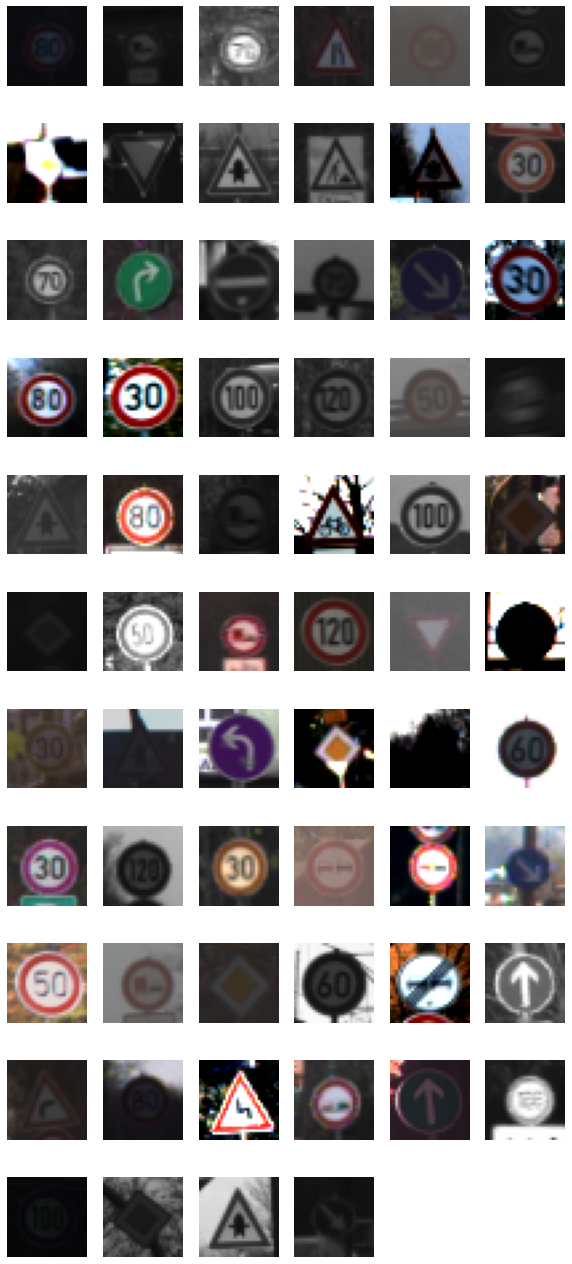

In [31]:
image_batch, label_batch = next(iter(dataVA_2))        
show_batch(image_batch, label_batch.numpy())

In [32]:
modelVA_2 = model_VI(NUM_CLASSES, 30, 3)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [33]:
file_pathVA_2 = os.path.join(MODELS_DIR, 'modelVA_2/cp.ckpt')

callbacksVA_2 = prepare_callbacks(file_pathVA_2)

Epoch 1/10
4411/4411 [==============================] - ETA: 0s - loss: 1.0815 - accuracy: 0.7049
Epoch 1: val_accuracy improved from -inf to 0.99388, saving model to Modelo/modelVA_2/cp.ckpt
4411/4411 [==============================] - 94s 18ms/step - loss: 1.0815 - accuracy: 0.7049 - val_loss: 0.0327 - val_accuracy: 0.9939 - lr: 1.0000e-04
Epoch 2/10
4408/4411 [============================>.] - ETA: 0s - loss: 0.2115 - accuracy: 0.9372
Epoch 2: val_accuracy improved from 0.99388 to 0.99872, saving model to Modelo/modelVA_2/cp.ckpt
4411/4411 [==============================] - 62s 14ms/step - loss: 0.2114 - accuracy: 0.9372 - val_loss: 0.0063 - val_accuracy: 0.9987 - lr: 1.0000e-04
Epoch 3/10
4410/4411 [============================>.] - ETA: 0s - loss: 0.1193 - accuracy: 0.9644
Epoch 3: val_accuracy improved from 0.99872 to 0.99987, saving model to Modelo/modelVA_2/cp.ckpt
4411/4411 [==============================] - 61s 14ms/step - loss: 0.1193 - accuracy: 0.9644 - val_loss: 0.0033 - 

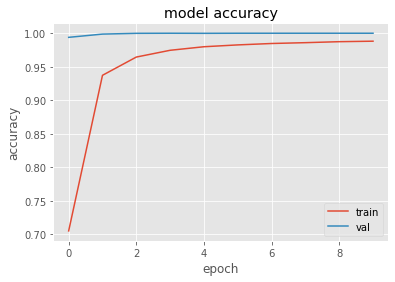

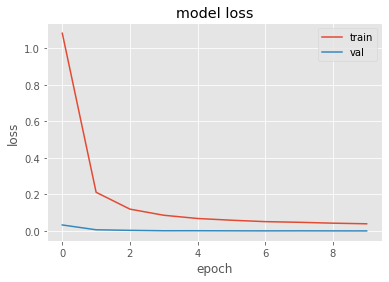

In [34]:
historyVA_2 = modelVA_2.fit(dataVA_2, epochs=10, validation_data = valset, callbacks = callbacksVA_2)     
show_history(historyVA_2)

In [35]:
modelVA_2.load_weights(file_pathVA_2)

evalVa_2 = modelVA_2.evaluate(testset, verbose=2)
valVA_2 = modelVA_2.evaluate(valset, verbose=2)

198/198 - 1s - loss: 0.0315 - accuracy: 0.9916 - 1s/epoch - 7ms/step
4/4 - 1s - loss: 0.0010 - accuracy: 1.0000 - 980ms/epoch - 245ms/step


## Comparação (Sem Data Augmentation/Dynamic/Massive)

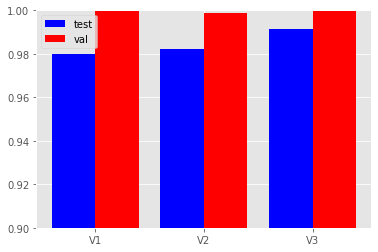

In [ ]:
show_accuracies(['V1', 'V2', 'V3'], [evalsolo[1], evalV2[1], evalVa[1]], [valsolo[1], valV2[1], valVA[1]])

## Ensembles

In [74]:
TRAIN_ONLINE = True

In [75]:
NUM_MODELS = 5
file_path_prefix = f'{MODELS_ENSEMBLES_DIR}V1'

### Criação da CNN

In [76]:
def create_model(classCount, imgSize, channels):

    modelLogits = Sequential()
    
    modelLogits.add(Conv2D(64, (5, 5), input_shape=(imgSize, imgSize, channels)))         
    modelLogits.add(LeakyReLU(alpha=0.01))  
    modelLogits.add(BatchNormalization())
    modelLogits.add(Dropout(0.5)) 

    modelLogits.add(Conv2D(128, (5, 5) )) 
    modelLogits.add(LeakyReLU(alpha=0.01))
    modelLogits.add(MaxPooling2D(pool_size=(2, 2)))
    modelLogits.add(BatchNormalization())
    modelLogits.add(Dropout(0.5)) 

    modelLogits.add(Conv2D(256, (5, 5) ) )   
    modelLogits.add(LeakyReLU(alpha=0.01))
    modelLogits.add(MaxPooling2D(pool_size=(2, 2)))
    modelLogits.add(BatchNormalization())
    modelLogits.add(Dropout(0.5)) 
    
    modelLogits.add(Flatten())
    modelLogits.add(LeakyReLU(alpha=0.0))       
    modelLogits.add(Dense(256))
    modelLogits.add(LeakyReLU(alpha=0.0))             
    modelLogits.add(Dropout(0.5)) 
    
    modelLogits.add(Dense(classCount))
    
    output = Activation('softmax')(modelLogits.output)

    model = tf.keras.Model(modelLogits.inputs, output)
    
    opt = Adam(lr=0.0001)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ 'accuracy'])
    return model, modelLogits

### Funções necessárias

In [102]:
def train_models(train, val,file_path_prefix):

    models = []
    histories = []
    
    for i in range(NUM_MODELS):

        model, modelL = create_model(NUM_CLASSES,IMAGE_SIZE,3)

        if TRAIN_ONLINE:
            callbacks = prepare_callbacks(f'{file_path_prefix}_{i:02}/cp.ckpt')
            hist = model.fit(train, epochs=30, validation_data = val, callbacks = callbacks)

        models.append([model, modelL])
        histories.append(hist)
    
    return models,histories

def load_weights(models, file_path_prefix):

    for i in range(NUM_MODELS):

        file_path = f'{file_path_prefix}_{i:02}/cp.ckpt'

        models[i][0].load_weights(file_path)
        models[i][0].save('temp.hdf5')
        models[i][1].load_weights('temp.hdf5', by_name=True)
    
def evaluate_models(models):
    
    accuracy = 0

    for i in range(NUM_MODELS):

        eval = models[i][0].evaluate(testset, verbose = 2)
        accuracy += eval[1]

    print(f'average accuracy: {(accuracy/NUM_MODELS)*100:.3f}')    

def get_labels_logits_and_preds(models):

    preds = [[] for _ in range(NUM_MODELS) ]
    logits = [[] for _ in range(NUM_MODELS)]
    labels = []
    for images, labs in testset.take(-1):

        labels.extend(labs.numpy())
        for i in range(NUM_MODELS):

            preds[i].extend(models[i][0].predict(images))
            logits[i].extend(models[i][1].predict(images))

    labels = [np.argmax(i) for i in labels]  
    
    return labels, logits, preds

def get_class_preds(preds):

    class_preds = []

    for i in range(test_dataset_length):

        c = []
        for m in range(NUM_MODELS):

            c.append(np.argmax(preds[m][i]))
        class_preds.append(c)
        
    return class_preds

def get_class_from_sum_of_logits(logits):

    sum_logits = []

    for i in range(test_dataset_length):

        log = logits[0][i]
        for m in range(1, NUM_MODELS):
            log = np.add(log, logits[m][i])
        sum_logits.append(np.argmax(log))
    return(sum_logits)
    
def get_stats(labels, class_preds, class_logits):
    all_correct = 0
    all_incorrect = 0
    maj_vote = 0
    maj_wrong = 0
    tie = 0
    count = 0
    log_ok = 0
    log_ko = 0

    for k in range(test_dataset_length):

        counter = collections.Counter(class_preds[k])
        if len(counter) == 1:
            if counter.most_common(1)[0][0] == labels[k]:
                all_correct += 1
            else:
                all_incorrect += 1
        else:
            aux = counter.most_common(2)
            if aux[0][1] > aux[1][1] and aux[0][0] == labels[k]:
                maj_vote += 1
            if aux[0][1] > aux[1][1] and aux[0][0] != labels[k]:
                maj_wrong += 1
            elif aux[0][1] == aux[1][1]:
                tie += 1
        if class_logits[k] == labels[k]:
            log_ok += 1
        else:
            log_ko += 1
        count += 1 
        
    return [count, all_correct, all_incorrect, maj_vote, tie, maj_wrong, log_ok, log_ko]

### Versão Solo

In [ ]:
models_V1, histories_V1 = train_models(dataSolo, valset, file_path_prefix)

In [ ]:
load_weights(models_V1, file_path_prefix)
evaluate_models(models_V1) #Avaliar o modelo

In [ ]:
labels_V1, logits_V1, preds_V1 = get_labels_logits_and_preds(models_V1)
class_preds_V1 = get_class_preds(preds_V1)
class_logits_V1 = get_class_from_sum_of_logits(logits_V1)   

res = get_stats(labels_V1, class_preds_V1, class_logits_V1)
print(res, res[6]/res[0])

### Versão Data Augmentation (Dynamic)

#### Versão 1

In [ ]:
file_path_prefix = f'{MODELS_ENSEMBLES_DIR}V2'    
models_V2, histories_V2 = train_models(dataV2, valset,file_path_prefix)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
489/491 [============================>.] - ETA: 0s - loss: 3.9783 - accuracy: 0.1393
Epoch 1: val_accuracy improved from -inf to 0.27251, saving model to Ensemble/V2_00/cp.ckpt
491/491 [==============================] - 17s 33ms/step - loss: 3.9757 - accuracy: 0.1398 - val_loss: 2.5396 - val_accuracy: 0.2725 - lr: 1.0000e-04
Epoch 2/30
489/491 [============================>.] - ETA: 0s - loss: 2.7778 - accuracy: 0.2980
Epoch 2: val_accuracy improved from 0.27251 to 0.61579, saving model to Ensemble/V2_00/cp.ckpt
491/491 [==============================] - 75s 153ms/step - loss: 2.7767 - accuracy: 0.2982 - val_loss: 1.2636 - val_accuracy: 0.6158 - lr: 1.0000e-04
Epoch 3/30
489/491 [============================>.] - ETA: 0s - loss: 2.1338 - accuracy: 0.4151
Epoch 3: val_accuracy improved from 0.61579 to 0.72622, saving model to Ensemble/V2_00/cp.ckpt
491/491 [==============================] - 16s 33ms/step - loss: 2.1338 - accuracy: 0.4152 - val_loss: 0.8685 - val_accuracy: 0.7

In [ ]:
load_weights(models_V2, file_path_prefix)
evaluate_models(models_V2) #Avaliar o modelo

198/198 - 1s - loss: 0.0445 - accuracy: 0.9873 - 1s/epoch - 7ms/step
198/198 - 1s - loss: 0.0528 - accuracy: 0.9852 - 1s/epoch - 6ms/step
198/198 - 1s - loss: 0.0593 - accuracy: 0.9816 - 1s/epoch - 6ms/step
198/198 - 1s - loss: 0.0582 - accuracy: 0.9807 - 1s/epoch - 6ms/step
198/198 - 1s - loss: 0.0700 - accuracy: 0.9769 - 1s/epoch - 6ms/step
average accuracy: 98.233


In [ ]:
labels_V2, logits_V2, preds_V2 = get_labels_logits_and_preds(models_V2)
class_preds_V2 = get_class_preds(preds_V2)
class_logits_V2 = get_class_from_sum_of_logits(logits_V2) 

res = get_stats(labels_V2, class_preds_V2, class_logits_V2)
print(res, res[6]/res[0]*100)

[12630, 12125, 27, 338, 20, 120, 12478, 152] 98.79651623119557


#### Versão 2

In [103]:
file_path_prefix = f'{MODELS_ENSEMBLES_DIR}V2_1'    
models_V2_1, histories_V2_1 = train_models(dataV2_1, valset,file_path_prefix)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
488/491 [============================>.] - ETA: 0s - loss: 3.4812 - accuracy: 0.1379
Epoch 1: val_accuracy improved from -inf to 0.16871, saving model to Ensemble/V2_1_00/cp.ckpt
491/491 [==============================] - 9s 16ms/step - loss: 3.4781 - accuracy: 0.1386 - val_loss: 2.9485 - val_accuracy: 0.1687 - lr: 1.0000e-04
Epoch 2/30
487/491 [============================>.] - ETA: 0s - loss: 2.1409 - accuracy: 0.4242
Epoch 2: val_accuracy improved from 0.16871 to 0.75249, saving model to Ensemble/V2_1_00/cp.ckpt
491/491 [==============================] - 8s 15ms/step - loss: 2.1365 - accuracy: 0.4253 - val_loss: 0.9503 - val_accuracy: 0.7525 - lr: 1.0000e-04
Epoch 3/30
490/491 [============================>.] - ETA: 0s - loss: 1.1782 - accuracy: 0.6562
Epoch 3: val_accuracy improved from 0.75249 to 0.90092, saving model to Ensemble/V2_1_00/cp.ckpt
491/491 [==============================] - 8s 16ms/step - loss: 1.1781 - accuracy: 0.6562 - val_loss: 0.3906 - val_accuracy: 0

In [104]:
load_weights(models_V2_1, file_path_prefix)
evaluate_models(models_V2_1) #Avaliar o modelo

198/198 - 2s - loss: 0.0589 - accuracy: 0.9826 - 2s/epoch - 8ms/step
198/198 - 2s - loss: 0.0721 - accuracy: 0.9816 - 2s/epoch - 8ms/step
198/198 - 2s - loss: 0.0701 - accuracy: 0.9806 - 2s/epoch - 8ms/step
198/198 - 1s - loss: 0.0687 - accuracy: 0.9816 - 1s/epoch - 8ms/step
198/198 - 1s - loss: 0.0676 - accuracy: 0.9810 - 1s/epoch - 8ms/step
average accuracy: 98.146


In [105]:
labels_V2_1, logits_V2_1, preds_V2_1 = get_labels_logits_and_preds(models_V2_1)
class_preds_V2_1 = get_class_preds(preds_V2_1)
class_logits_V2_1 = get_class_from_sum_of_logits(logits_V2_1) 

res = get_stats(labels_V2_1, class_preds_V2_1, class_logits_V2_1)
print(res, res[6]/res[0]*100)

[12630, 12226, 51, 188, 19, 146, 12426, 204] 98.38479809976248


#### Versão 3

In [106]:
file_path_prefix = f'{MODELS_ENSEMBLES_DIR}V2_2'    
models_V2_2, histories_V2_2 = train_models(dataV2_2, valset,file_path_prefix)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
490/491 [============================>.] - ETA: 0s - loss: 3.1517 - accuracy: 0.2140
Epoch 1: val_accuracy improved from -inf to 0.33257, saving model to Ensemble/V2_2_00/cp.ckpt
491/491 [==============================] - 9s 16ms/step - loss: 3.1515 - accuracy: 0.2140 - val_loss: 2.4987 - val_accuracy: 0.3326 - lr: 1.0000e-04
Epoch 2/30
489/491 [============================>.] - ETA: 0s - loss: 1.5074 - accuracy: 0.5775
Epoch 2: val_accuracy improved from 0.33257 to 0.87325, saving model to Ensemble/V2_2_00/cp.ckpt
491/491 [==============================] - 9s 17ms/step - loss: 1.5060 - accuracy: 0.5778 - val_loss: 0.5476 - val_accuracy: 0.8732 - lr: 1.0000e-04
Epoch 3/30
488/491 [============================>.] - ETA: 0s - loss: 0.7774 - accuracy: 0.7680
Epoch 3: val_accuracy improved from 0.87325 to 0.93216, saving model to Ensemble/V2_2_00/cp.ckpt
491/491 [==============================] - 8s 16ms/step - loss: 0.7765 - accuracy: 0.7682 - val_loss: 0.2638 - val_accuracy: 0

In [107]:
load_weights(models_V2_2, file_path_prefix)
evaluate_models(models_V2_2) #Avaliar o modelo

198/198 - 1s - loss: 0.0728 - accuracy: 0.9799 - 1s/epoch - 6ms/step
198/198 - 1s - loss: 0.0738 - accuracy: 0.9795 - 1s/epoch - 6ms/step
198/198 - 1s - loss: 0.0943 - accuracy: 0.9724 - 1s/epoch - 6ms/step
198/198 - 1s - loss: 0.0864 - accuracy: 0.9778 - 1s/epoch - 6ms/step
198/198 - 1s - loss: 0.0730 - accuracy: 0.9797 - 1s/epoch - 6ms/step
average accuracy: 97.785


In [108]:
labels_V2_2, logits_V2_2, preds_V2_2 = get_labels_logits_and_preds(models_V2_2)
class_preds_V2_2 = get_class_preds(preds_V2_2)
class_logits_V2_2 = get_class_from_sum_of_logits(logits_V2_2) 

res = get_stats(labels_V2_2, class_preds_V2_2, class_logits_V2_2)
print(res, res[6]/res[0]*100)

[12630, 12110, 40, 271, 33, 176, 12397, 233] 98.15518606492478


### Versão Data Augmentation (Massive)

In [ ]:
file_path_prefix = f'{MODELS_ENSEMBLES_DIR}V3'    
models_V3, histories_V3 = train_models(dataVA, valset,file_path_prefix)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
3919/3921 [============================>.] - ETA: 0s - loss: 1.2413 - accuracy: 0.6733
Epoch 1: val_accuracy improved from -inf to 0.98508, saving model to Ensemble/V3_00/cp.ckpt
3921/3921 [==============================] - 55s 14ms/step - loss: 1.2409 - accuracy: 0.6734 - val_loss: 0.0722 - val_accuracy: 0.9851 - lr: 1.0000e-04
Epoch 2/10
3918/3921 [============================>.] - ETA: 0s - loss: 0.3043 - accuracy: 0.9114
Epoch 2: val_accuracy improved from 0.98508 to 0.99656, saving model to Ensemble/V3_00/cp.ckpt
3921/3921 [==============================] - 55s 14ms/step - loss: 0.3042 - accuracy: 0.9114 - val_loss: 0.0155 - val_accuracy: 0.9966 - lr: 1.0000e-04
Epoch 3/10
3920/3921 [============================>.] - ETA: 0s - loss: 0.1660 - accuracy: 0.9509
Epoch 3: val_accuracy improved from 0.99656 to 0.99911, saving model to Ensemble/V3_00/cp.ckpt
3921/3921 [==============================] - 55s 14ms/step - loss: 0.1659 - accuracy: 0.9509 - val_loss: 0.0048 - val_ac

In [ ]:
load_weights(models_V3, file_path_prefix)
evaluate_models(models_V3)

198/198 - 1s - loss: 0.0232 - accuracy: 0.9929 - 1s/epoch - 6ms/step
198/198 - 1s - loss: 0.0365 - accuracy: 0.9876 - 1s/epoch - 6ms/step
198/198 - 1s - loss: 0.0280 - accuracy: 0.9923 - 1s/epoch - 6ms/step
198/198 - 1s - loss: 0.0261 - accuracy: 0.9933 - 1s/epoch - 6ms/step
198/198 - 1s - loss: 0.0205 - accuracy: 0.9946 - 1s/epoch - 6ms/step
average accuracy: 99.213


In [ ]:
labels_V3, logits_V3, preds_V3 = get_labels_logits_and_preds(models_V3)
class_preds_V3 = get_class_preds(preds_V3)
class_logits_V3 = get_class_from_sum_of_logits(logits_V3) 

res = get_stats(labels_V3, class_preds_V3, class_logits_V3)
print(res, res[6]/res[0])

[12630, 12408, 14, 149, 10, 49, 12561, 69] 0.9945368171021378
